# Uncertainty-Aware Road Obstacle Identification

In this notebook, we propose an implementation of Road Obstacle Identification architecture, with the addition of a certain threshold of confidence to uncertainty, thanks to a state-of-the-art approach to loss function computations, the so called "Boundary Aware Binary Cross Entropy". These are the main implemented topics:
- **Multilabel One-Hot Encoding**
- **DeepLabV3+ --> ResNet50**
- **Boundary Aware BCE**

## Import Necessary Libraries

In [1]:
#import sklearn
import os
from PIL import Image
import torch
import torch.nn as nn
from tqdm import tqdm
import cv2
import numpy as np
import random
import shutil
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
#import segmentation_models_pytorch as smp
import torch.optim as optim

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version PyTorch was built with: {torch.version.cuda}")
try:
    print(f"CUDA runtime version: {torch._C._cuda_getCompiledVersion()}")
except AttributeError:
    print("CUDA is not available, running on CPU.")

PyTorch version: 2.7.0+cu126
Torchvision version: 0.22.0+cu126
CUDA available: True
CUDA version PyTorch was built with: 12.6
CUDA runtime version: 12060


In [2]:
def set_seed(seed=1996734):
    random.seed(seed)                      # Python
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch GPU

set_seed(1996734)  # Call this at the top of your script

## Globals

In [3]:
# Macro class index mapping
MACRO_CLASSES = {
    "road": 0,
    "flat": 1,
    "human": 2,
    "vehicle": 3,
    "construction": 4,
    "background": 5,
    "object": 6,  # auxiliary objectness channel
}

# Map from original label ID to (macro class or None, is_object)   [None is only for the poles and traffic signs and lights]
CLASS_MAPPING = {
    7: ("road", False), # road
    8: ("flat", False), # sidewalk
    11: ("construction", False), # building
    12: ("construction", False), # wall
    13: ("construction", False), # fence
    17: ("construction", True),  # pole
    19: ("construction", True),  # traffic sign
    20: ("construction", True),  # traffic light
    21: ("background", False), # vegetation
    22: ("flat", False), # terrain
    23: ("background", False), # sky
    24: ("human", True), # person
    25: ("human", True), # rider
    26: ("vehicle", True), # car
    27: ("vehicle", True), # truck
    28: ("vehicle", True), # bus
    31: ("vehicle", True), # train
    32: ("vehicle", True), # motorcycle
    33: ("vehicle", True), # bicycle
}

# Set the relative path for the dataset
relative_path = '../../'

## Utils

### Preprocessing

**Fixing the Datasets**

Here is the function to fix the structure of the two datasets, downloaded from the official CityScapes and LostAndFound websites, from their original form to a preferred one, following the structure defined therein

In [ ]:
def fix_cityscapes(path_in, path_out, image_folder_in="leftImg8bit", mask_folder_in="gtFine", is_delete=False): # is_delete=True if you want to delete the city folders after copying
    """
    Fixes the CityScapes dataset by renaming the files and removing the city folders.
    """
    splits = ['train', 'val', 'test']
   
    for split in splits:
        count = 1
        img_dir = os.path.join(path_in, image_folder_in, split)
        mask_dir = os.path.join(path_in, mask_folder_in, split)

        # New destination directories
        img_out = os.path.join(path_out, 'img', split)
        mask_out = os.path.join(path_out, 'mask', split)
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(mask_out, exist_ok=True)

        # Iterate on sub-folders
        for city in os.listdir(img_dir):
            city_img_dir = os.path.join(img_dir, city)
            city_mask_dir = os.path.join(mask_dir, city)

            if not os.path.isdir(city_img_dir):
                continue  # Skips non-directory files

            for filename in os.listdir(city_img_dir):
                if not filename.endswith('leftImg8bit.png'):
                    continue
                img_path = os.path.join(city_img_dir, filename)
                base_prefix = filename.replace('_leftImg8bit.png', '')

                # Renames and copies RGB
                new_base = f"{split}{count}"
                ext = '.png'
                new_img_name = f"{new_base}{ext}"
                shutil.copy(img_path, os.path.join(img_out, new_img_name))

                if split != 'test': # For test split, we only copy the image
                    # Renames and copies all 'label' associated files
                    suffixes = ['_gtFine_labelIds.png', '_gtFine_color.png', '_gtFine_instanceIds.png', '_gtFine_polygons.json']
                    for suffix in suffixes:
                        if suffix == '_gtFine_labelIds.png':
                            original_name = base_prefix + suffix
                            source = os.path.join(city_mask_dir, original_name)
                            if os.path.exists(source):
                                new_name = f"{new_base}_m.png"  # es. train1_m.png
                                shutil.copy(source, os.path.join(mask_out, new_name))
                        else:
                            continue
                count += 1
                    
            if is_delete:        
                # Cleans city folders if empty
                if os.path.isdir(city_img_dir) and not os.listdir(city_img_dir):
                    os.rmdir(city_img_dir)
                if os.path.isdir(city_mask_dir) and not os.listdir(city_mask_dir):
                    os.rmdir(city_mask_dir)

                # Removes split folders if empty
                for d in [img_dir, mask_dir]:
                    if os.path.isdir(d) and not os.listdir(d):
                        os.rmdir(d)

is_fixed = True
if not is_fixed:
    print("Fixing cityscapes dataset...")
    # Fix the dataset
    fix_cityscapes(relative_path + 'cityscapes', relative_path + 'cityscapes_f')

In [ ]:
def fix_lostandfound(path_in, path_out, image_folder_in="leftImg8bit", mask_folder_in="gtCoarse", is_delete=False): # is_delete=True if you want to delete the city folders after copying
    """
    Fixes the LostAndFound dataset by renaming the files and removing the city folders.
    """
    splits = ['train', 'test']
   
    for split in splits:
        count = 1
        img_dir = os.path.join(path_in, image_folder_in, split)
        mask_dir = os.path.join(path_in, mask_folder_in, split)

        # New destination directories
        img_out = os.path.join(path_out, 'img', split)
        mask_out = os.path.join(path_out, 'mask', split)
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(mask_out, exist_ok=True)

        # Iterate on sub-folders
        for city in os.listdir(img_dir):
            city_img_dir = os.path.join(img_dir, city)
            city_mask_dir = os.path.join(mask_dir, city)

            if not os.path.isdir(city_img_dir):
                continue  # Skips non-directory files

            for filename in os.listdir(city_img_dir):
                if not filename.endswith('leftImg8bit.png'):
                    continue
                img_path = os.path.join(city_img_dir, filename)
                base_prefix = filename.replace('_leftImg8bit.png', '')

                # Renames and copies RGB
                new_base = f"{split}{count}"
                ext = '.png'
                new_img_name = f"{new_base}{ext}"
                shutil.copy(img_path, os.path.join(img_out, new_img_name))

                if split != 'test': # For test split, we only copy the image
                    # Renames and copies all 'label' associated files
                    suffixes = ['_gtCoarse_labelIds.png', '_gtCoarse_color.png', '_gtCoarse_instanceIds.png', '_gtCoarse_labelTrainIds.png', '_gtCoarse_polygons.json']
                    for suffix in suffixes:
                        if suffix == '_gtCoarse_labelIds.png':
                            original_name = base_prefix + suffix
                            source = os.path.join(city_mask_dir, original_name)
                            if os.path.exists(source):
                                new_name = f"{new_base}_m.png"  # es. train1_m.png
                                shutil.copy(source, os.path.join(mask_out, new_name))
                        else:
                            continue
                count += 1
                    
            if is_delete:        
                # Cleans city folders if empty
                if os.path.isdir(city_img_dir) and not os.listdir(city_img_dir):
                    os.rmdir(city_img_dir)
                if os.path.isdir(city_mask_dir) and not os.listdir(city_mask_dir):
                    os.rmdir(city_mask_dir)

                # Removes split folders if empty
                for d in [img_dir, mask_dir]:
                    if os.path.isdir(d) and not os.listdir(d):
                        os.rmdir(d)

is_fixed = True
if not is_fixed:
    print("Fixing lostandfound dataset...")
    # Fix the dataset
    fix_lostandfound(relative_path + 'lostandfound', relative_path + 'lostandfound_f')

**Converting Data**

With these functions, we convert labels and images from the dataset into PyTorch tensors, in order to feed them to the network and begin the training process

In [4]:
# Prepare a mapping from original labels to macro class index (0 to 6)
# For original labels mapped to None macro class (like poles, signs, lights), only 'object' class (6) will be set.

LABEL_TO_MACRO_IDX = {}

for original_id, (macro_class, is_object) in CLASS_MAPPING.items():
    if macro_class is not None:
        LABEL_TO_MACRO_IDX[original_id] = MACRO_CLASSES[macro_class]
    else:
        # For None macro class, we don't assign a macro_idx (only object channel will be set)
        LABEL_TO_MACRO_IDX[original_id] = None


def convert_label_to_multilabel_one_hot(label):
    """
    Converts 2D label mask [H, W] with Cityscapes original IDs into a multi-label one-hot encoding tensor [7, H, W].
    The last channel (index 6) corresponds to the 'object' auxiliary channel.
    """

    # Get the spatial dimensions of the label mask
    height, width = label.shape

    # Initialize the output tensor with 7 channels (macro-classes), filled with zeros.
    # Each channel corresponds to a macro-class.
    multilabel = torch.zeros((7, height, width), dtype=torch.float32)

    # Iterate over each original class ID defined in the CLASS_MAPPING
    for original_id, (_, is_object) in CLASS_MAPPING.items():

        # Create a boolean mask of where the input label equals the current original class ID
        mask = (label == original_id)

        # Look up the macro-class index for this class ID, or None if it doesn't belong to any
        macro_idx = LABEL_TO_MACRO_IDX[original_id]

        # If this class maps to a macro-class, set 1 at those pixel locations in the corresponding channel
        if macro_idx is not None:
            multilabel[macro_idx][mask] = 1.0  # Set the macro-class channel to 1 where the mask is True

        # If this class is considered an 'object', also set the 'object' channel (index 6) to 1
        if is_object:
            multilabel[MACRO_CLASSES["object"]][mask] = 1.0  # Set the object class channel to 1

    # Return the resulting multi-label one-hot tensor of shape [7, H, W]
    return multilabel

**Boundaries Detection**

Here we compute the boundary mask on the ground truth segmentation labels, to tell the model “this is a boundary region, pay more attention here”.

To do that we use morphological gradient (difference between the dilation and the erosion of the image):
- **Dilation**: expand the region of each class, boundary pixels move away from the center of the region (each pixel replaced with maximum value in its neighborhood)
- **Erosion**: reduce the region of each class, boundary pixels move toward the center of the region (each pixel replaced with minimum value in its neighborhood)

In [5]:
def get_boundary_mask(label_mask, kernel_size=3):
    """
    Computes the boundary mask from a label mask using morphological operations.
    Args:
        label_mask (numpy.ndarray): Input label mask with shape [H, W].
        kernel_size (int): Size of the kernel for morphological operations.
    Returns:
        numpy.ndarray: Boundary mask with shape [H, W].
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(label_mask, kernel, iterations=2)
    eroded = cv2.erode(label_mask, kernel, iterations=2)
    boundary = (dilated != eroded).astype(np.uint8)
    return boundary

To process multiple masks in parallel:

In [6]:
def get_boundary_mask_batch(label_masks, kernel_size=3, iterations=2):
    """
    Computes the boundary mask for a batch of label masks using morphological operations.
    Args:
        label_masks (torch.Tensor): Tensor of shape [B, H, W] or [B, 1, H, W], with binary masks (0 or 1).
        kernel_size (int): Size of the kernel for morphological operations.
        iterations (int): Number of times to apply dilation and erosion.
    Returns:
        torch.Tensor: Boundary masks of shape [B, H, W], dtype=torch.uint8.
    """

    if label_masks.dim() == 3:
        label_masks = label_masks.unsqueeze(1)  # [B, 1, H, W]

    # Ensure float type for convolution
    label_masks = label_masks.float()

    # Define kernel (morphological structuring element)
    device = label_masks.device
    kernel = torch.ones((1, 1, kernel_size, kernel_size), device=device)

    padding = kernel_size // 2

    # Apply dilation
    dilated = label_masks
    for _ in range(iterations):
        dilated = F.conv2d(dilated, kernel, padding=padding)
        dilated = (dilated > 0).float()

    # Apply erosion
    eroded = label_masks
    for _ in range(iterations):
        eroded = F.conv2d(eroded, kernel, padding=padding)
        eroded = (eroded == kernel.numel()).float()

    # Compute boundary: difference between dilated and eroded regions
    boundary = (dilated != eroded).float()

    return boundary.squeeze(1).byte()  # Return shape [B, H, W], uint8

### Visualization

Some functions to show the aforementioned preprocessing, useful to visualize the data we are working with

In [7]:
class_names_7 = ["road", "flat", "human", "vehicle", "construction", "background", "object"]

def visualize_one_hot_vertical(one_hot, class_names=None, max_classes=7):
    """
    Visualizes the one-hot encoded masks vertically.
    """
    num_classes = min(one_hot.shape[0], max_classes)
    fig, axes = plt.subplots(num_classes, 1, figsize=(5, 3 * num_classes))

    for i in range(num_classes):
        ax = axes[i]
        ax.imshow(one_hot[i], cmap='gray')
        title = f"Class {i}" if class_names is None else class_names[i]
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
def visualize_erosion_mask(label_mask):
    """
    Visualizes the erosion mask of a label mask.
    """
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(label_mask, kernel, iterations=2)
    plt.figure()
    plt.imshow(erosion, cmap='gray')
    plt.title("Erosion Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_dilation_mask(label_mask):
    """
    Visualizes the dilation mask of a label mask.
    """
    kernel = np.ones((3, 3), np.uint8)
    dilation = cv2.dilate(label_mask, kernel, iterations=2)
    plt.figure()
    plt.imshow(dilation, cmap='gray')
    plt.title("Dilation Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_boundary_mask(label_mask):
    """
    Visualizes the boundary mask.
    """
    boundary = get_boundary_mask(label_mask)
    plt.figure()
    plt.imshow(boundary, cmap='gray')
    plt.title("Boundary Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
def uos_heatmap(img_tensor, uos_tensor):
    """
    Superpose the heatmap of the unknown objectness score to the image.
    img_tensor: [3, H, W], torch.Tensor in [0, 1] or [0, 255]
    uos_tensor: [H, W], torch.Tensor
    """
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    uos = uos_tensor.cpu().numpy()
    uos = (uos - uos.min()) / (uos.max() - uos.min() + 1e-6)  # normalize

    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.imshow(uos, cmap='hot', alpha=0.5)
    plt.title("Unknown Objectness Score Heatmap for val_set")
    plt.colorbar()
    plt.axis('off')
    plt.show()

## Data

In [10]:
# Define the transformation for images
##############

resized_height = 512
resized_width = 1024

transform = T.Compose([
    T.Resize((resized_height, resized_width)),  # Resize to half the original size
    T.ToTensor(),  # converts in [0, 1], shape [3, H, W]
    T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

#############

class CityscapesTrainEvalDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=transform):
        self.transform = transform 
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)

        # Collect all image paths
        self.img_paths = list(self.img_dir.rglob("*.png"))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        # Derive corresponding mask path by adding '_m' before the extension
        mask_name = img_path.stem + "_m.png"
        mask_path = self.mask_dir / mask_name

        if not mask_path.exists():
            print(f"Warning: No mask found for image: {img_path.name}")

        # Load and preprocess image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        else:
            img = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])(img)

        # Load and preprocess mask
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale (single channel)

        # Resize mask with nearest neighbor interpolation
        resized_mask = mask.resize((resized_width, resized_height), resample=Image.NEAREST)

        mask_np = np.array(resized_mask, dtype=np.uint8)

        mask_tensor = torch.as_tensor(mask_np, dtype=torch.uint8)

        mask_onehot = convert_label_to_multilabel_one_hot(mask_tensor)

        return img, mask_onehot, mask_np
    

class CityscapesTestDataset(Dataset):
    def __init__(self, img_dir, transform=transform):
        self.img_paths = sorted(Path(img_dir).rglob("*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        else:
            img = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])(img)

        return img, str(img_path.name)  # Return the filename for later use

In [11]:
train_set = CityscapesTrainEvalDataset(relative_path + 'cityscapes_f/img/train', relative_path + 'cityscapes_f/mask/train')
val_set = CityscapesTrainEvalDataset(relative_path + 'cityscapes_f/img/val', relative_path + 'cityscapes_f/mask/val')
test_set = CityscapesTestDataset(relative_path + 'cityscapes_f/img/test')

batch_size = 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True) # drop_last=True to ensure all batches have the same size
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

for imgs, masks, original_mask in val_loader:
    print("Batch of images shape:", imgs.shape)  # Should be [B, 3, H, W]
    print("Batch of masks shape:", masks.shape)  # Should be [B, 7, H, W]
    print("Original mask shape:", original_mask.shape)  # Should be [B, H, W]
    break  # Just to check the first batch

Batch of images shape: torch.Size([4, 3, 512, 1024])
Batch of masks shape: torch.Size([4, 7, 512, 1024])
Original mask shape: torch.Size([4, 512, 1024])


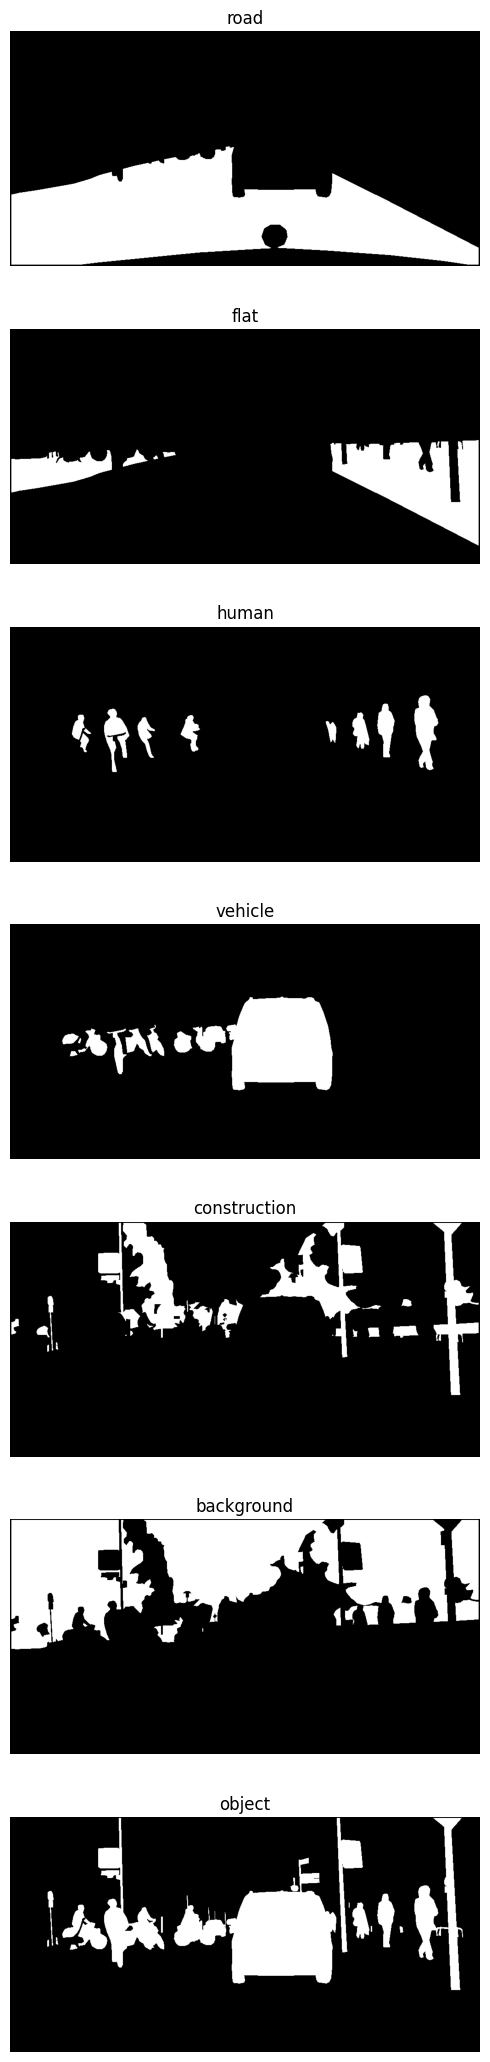

In [14]:
visualize_one_hot_vertical(masks[1], class_names=class_names_7)

## Network

In [12]:
class MultiLabelDeepLabV3(nn.Module):
    def __init__(self, n_classes=7):
        super().__init__()
        # Load pretrained model
        self.model = deeplabv3_resnet50(pretrained=True)
        
        # Replace classifier to output 7 channels with sigmoid
        self.model.classifier[-1] = nn.Conv2d(
            in_channels=256,
            out_channels=n_classes,
            kernel_size=1
        )
    
    def forward(self, x):
        x = self.model(x)['out']
        return torch.sigmoid(x)  # Apply sigmoid for multilabel outputs

### Loss Function

**Boundary Aware BCE**

Following the format of how to create a custom loss function according to:
https://medium.com/we-talk-data/crafting-custom-loss-functions-in-pytorch-an-advanced-guide-830ff717163e

- lambda_weight: weight lambda of the formula
- pred: tensor of the outputs of the sigmoid head, the dimension is (B, C, H, W) with B batch size, C classes ...
- target: ground truth one hot encoded with dimension (B, C, H, W)
- boundary_mask: mask computed using get_boundary_mask() where 1 indicates boundary pixel, dimension (B, 1, H, W)

In [13]:
class BoundaryAwareBCELoss(nn.Module):
    def __init__(self, lambda_weight=3.0):
        super().__init__()
        self.lambda_weight = lambda_weight

    def forward(self, pred, target, boundary_mask):
        #to avoid log(0)
        eps = 1e-7

        # Identify pixels to include: those with at least one class active
        # target shape: (B, C, H, W)
        include_mask = (target.sum(dim=1) > 0).float()  # shape: (B, H, W)

        #standard BCE loss
        bce = -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps)) # shape (B, C, H, W)
            
        # Normal term: mean BCE over included pixels only
        # Expand include_mask to (B, C, H, W) to apply to all channels
        include_mask_exp = include_mask.unsqueeze(1).expand_as(bce)  # shape (B, C, H, W)

        # Apply mask: ignore pixels where all classes are zero
        bce_masked = bce * include_mask_exp

        # Compute mean only over included pixels (avoid dividing by zero)
        normal_term = bce_masked.sum() / include_mask_exp.sum().clamp(min=1.0)
        boundary_mask = boundary_mask.float()
        #expansion to (B, C, H, W) to do the multiplication

        # Boundary mask expansion and boundary aware loss (only where include_mask is True)
        if boundary_mask.dim() == 3:
            boundary_mask = boundary_mask.unsqueeze(1)
        boundary_mask = boundary_mask.expand_as(pred)

        # Combine boundary mask with include_mask to ignore zero-class pixels
        combined_mask = boundary_mask * include_mask_exp

        boundary_bce = bce * combined_mask
        num_boundary_pixels = combined_mask.sum(dim=(1, 2, 3)).clamp(min=1.0)
        boundary_loss = boundary_bce.sum(dim=(1, 2, 3)) / num_boundary_pixels
        boundary_term = boundary_loss.mean()

        return normal_term + self.lambda_weight * boundary_term

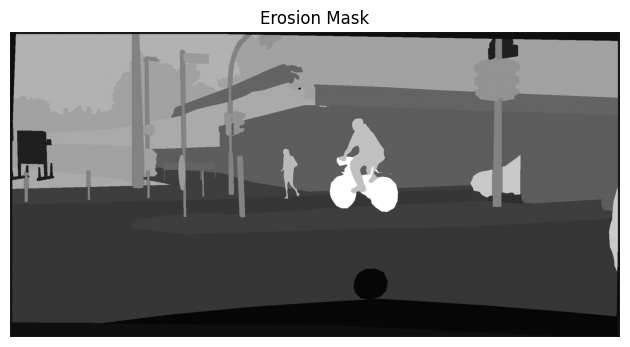

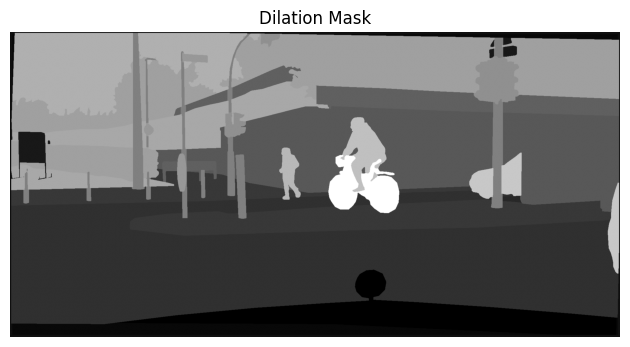

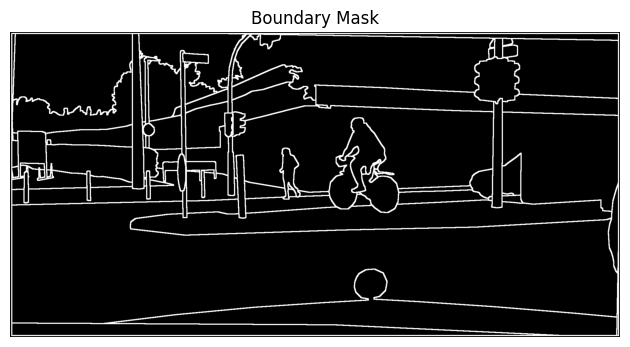

In [14]:
visualize_erosion_mask(np.array(Image.open(relative_path + 'cityscapes_f/mask/train/train1_m.png')))
visualize_dilation_mask(np.array(Image.open(relative_path + 'cityscapes_f/mask/train/train1_m.png')))
visualize_boundary_mask(np.array(Image.open(relative_path + 'cityscapes_f/mask/train/train1_m.png')))

## Train

### Training from scratch

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiLabelDeepLabV3(n_classes=7).to(device)

criterion = BoundaryAwareBCELoss(lambda_weight=3.0)

# Parameters
initial_lr = 0.01
momentum = 0.9
weight_decay = 0.0001
power = 0.9
num_epochs = 3
boundary_iterations = 5

optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)

# Calculate max iterations for poly schedule
max_iter = num_epochs * len(train_loader)
current_iter = 0

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0
early_stop = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for imgs, masks, original_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        boundary_masks = get_boundary_mask_batch(original_mask, iterations=boundary_iterations).to(device)
        loss = criterion(preds, masks, boundary_masks)
        loss.backward()
        optimizer.step()

        # Poly LR update
        current_iter += 1
        lr = initial_lr * (1 - current_iter / max_iter) ** power
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
    # ---- VALIDATION STEP ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks, original_mask in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            boundary_masks = get_boundary_mask_batch(original_mask, iterations=boundary_iterations).to(device)
            loss = criterion(preds, masks, boundary_masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {lr:.6f}")
    
    # ---- EARLY STOPPING LOGIC ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save best model
        torch.save(model.state_dict(), 'weights/best_model_boundary_5_lambda_3.0.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            early_stop = True
            break

/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 743/743 [09:30<00:00,  1.30it/s]


Epoch [1/3] | Train Loss: 0.3008 | Val Loss: 0.2012 | LR: 0.006943


Epoch 2: 100%|██████████| 743/743 [09:23<00:00,  1.32it/s]


Epoch [2/3] | Train Loss: 0.1661 | Val Loss: 0.1802 | LR: 0.003720


Epoch 3: 100%|██████████| 743/743 [09:33<00:00,  1.29it/s]


Epoch [3/3] | Train Loss: 0.1447 | Val Loss: 0.1639 | LR: 0.000000


In [16]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'current_iter': current_iter,
}, 'weights/new_model_boundary_5_lambda_3.0.pth')

### Resume the training from a checkpoint

In [ ]:
# --- Model and Loss ---
model = MultiLabelDeepLabV3(n_classes=7)
criterion = BoundaryAwareBCELoss(lambda_weight=3.0)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Optimizer Setup ---
initial_lr = 0.01
momentum = 0.9
weight_decay = 0.0001
power = 0.9
resume_epochs = 1  # how many more epochs to train
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)

# --- Early Stopping ---
patience = 3
counter = 0
early_stop = False

# --- Checkpoint Info ---
weights_name = "new_model_boundary_5_lambda_3.0.pth" # Name of the weights file, e.g., "model_weights.pth"
checkpoint_path = "weights/" + weights_name
output_path = "weights/updated_" + weights_name # It changes during training
start_epoch = 0
current_iter = 0
best_val_loss = float("inf")

# --- Load Checkpoint if Exists ---
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    current_iter = checkpoint['current_iter']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resumed at epoch {start_epoch}, iter {current_iter}, best val loss {best_val_loss:.4f}")

# --- Training Setup ---
total_epochs = start_epoch + resume_epochs
max_iter = total_epochs * len(train_loader)

# --- Training Loop ---
for epoch in range(start_epoch, total_epochs):
    model.train()
    running_loss = 0.0

    for imgs, masks, original_mask in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()

        preds = model(imgs)
        boundary_masks = get_boundary_mask_batch(original_mask).to(device)

        loss = criterion(preds, masks, boundary_masks)
        loss.backward()
        optimizer.step()

        # Poly LR scheduling
        current_iter += 1
        lr = initial_lr * (1 - current_iter / max_iter) ** power
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks, original_mask in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            boundary_masks = get_boundary_mask_batch(original_mask).to(device)
            loss = criterion(preds, masks, boundary_masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{total_epochs}] | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | LR: {lr:.6f}")

    # --- Early Stopping ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), output_path)
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            early_stop = True
            break

    output_path = f"weights/updated_{weights_name}_{epoch + 1}.pth"
    # --- Save Checkpoint ---
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'current_iter': current_iter,
        'best_val_loss': best_val_loss
    }, output_path)

/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading checkpoint from weights/best_model_boundary_5_lambda_3.0.pth


KeyError: 'model_state_dict'

### Hyperparameter tuning

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameter ranges
boundary_iteration_param = [3, 5, 7]  # arguments for get_boundary_mask_batch
lambda_weights = [3.0]  # different lambda weights for BCE loss

# Training parameters
initial_lr = 0.01
momentum = 0.9
weight_decay = 0.0001
power = 0.9
num_epochs = 1
patience = 3

os.makedirs('weights', exist_ok=True)

for boundary_iteration in boundary_iteration_param:
    for lambda_weight in lambda_weights:
        print(f"\n🔧 Starting training with get_boundary_mask_batch={boundary_iteration} and lambda={lambda_weight}\n")

        # Model and loss
        model = MultiLabelDeepLabV3(n_classes=7).to(device)
        criterion = BoundaryAwareBCELoss(lambda_weight=lambda_weight)
        optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
        
        max_iter = num_epochs * len(train_loader)
        current_iter = 0

        best_val_loss = float('inf')
        counter = 0
        early_stop = False

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            
            for imgs, masks, original_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                imgs, masks = imgs.to(device), masks.to(device)
                optimizer.zero_grad()
                preds = model(imgs)
                boundary_masks = get_boundary_mask_batch(original_mask, iterations=boundary_iteration).to(device)
                loss = criterion(preds, masks, boundary_masks)
                loss.backward()
                optimizer.step()

                # Poly LR schedule
                current_iter += 1
                lr = initial_lr * (1 - current_iter / max_iter) ** power
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                
                running_loss += loss.item()
            
            avg_train_loss = running_loss / len(train_loader)

            # ---- VALIDATION ----
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for imgs, masks, original_mask in val_loader:
                    imgs, masks = imgs.to(device), masks.to(device)
                    preds = model(imgs)
                    boundary_masks = get_boundary_mask_batch(original_mask, iterations=boundary_iteration).to(device)
                    loss = criterion(preds, masks, boundary_masks)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)

            print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {lr:.6f}")

            # ---- EARLY STOPPING AND MODEL SAVING ----
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                counter = 0
                # Save best model
                filename = f"weights/model_boundary_{boundary_iteration}_lambda_{lambda_weight}.pth"
                torch.save(model.state_dict(), filename)
            else:
                counter += 1
                if counter >= patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
                    early_stop = True
                    break



🔧 Starting training with get_boundary_mask_batch=3 and lambda=3.0



/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 743/743 [08:26<00:00,  1.47it/s]


Epoch [1/1] | Train Loss: 0.3040 | Val Loss: 0.2000 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=3 and lambda=5.0



Epoch 1: 100%|██████████| 743/743 [08:12<00:00,  1.51it/s]


Epoch [1/1] | Train Loss: 0.4199 | Val Loss: 0.2856 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=3 and lambda=8.0



Epoch 1:  39%|███▉      | 292/743 [03:13<05:11,  1.45it/s]

##### Output

🔧 Starting training with get_boundary_mask_batch=3 and lambda=3.0

Epoch 1: 100%|██████████| 743/743 [08:22<00:00,  1.48it/s]
Epoch [1/1] | Train Loss: 0.3606 | Val Loss: 0.2576 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=3 and lambda=5.0

Epoch 1: 100%|██████████| 743/743 [08:10<00:00,  1.52it/s]
Epoch [1/1] | Train Loss: 0.5003 | Val Loss: 0.3691 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=3 and lambda=8.0

Epoch 1: 100%|██████████| 743/743 [08:13<00:00,  1.51it/s]
Epoch [1/1] | Train Loss: 0.7100 | Val Loss: 0.5326 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=4 and lambda=3.0

Epoch 1: 100%|██████████| 743/743 [08:47<00:00,  1.41it/s]
Epoch [1/1] | Train Loss: 0.3573 | Val Loss: 0.2527 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=4 and lambda=5.0

Epoch 1: 100%|██████████| 743/743 [08:48<00:00,  1.41it/s]
Epoch [1/1] | Train Loss: 0.5022 | Val Loss: 0.3632 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=4 and lambda=8.0

Epoch 1: 100%|██████████| 743/743 [08:43<00:00,  1.42it/s]
Epoch [1/1] | Train Loss: 0.7044 | Val Loss: 0.5229 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=5 and lambda=3.0

Epoch 1: 100%|██████████| 743/743 [09:27<00:00,  1.31it/s]
Epoch [1/1] | Train Loss: 0.3573 | Val Loss: 0.2531 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=5 and lambda=5.0

Epoch 1: 100%|██████████| 743/743 [09:40<00:00,  1.28it/s]
Epoch [1/1] | Train Loss: 0.5001 | Val Loss: 0.3661 | LR: 0.000000

🔧 Starting training with get_boundary_mask_batch=5 and lambda=8.0

Epoch 1: 100%|██████████| 743/743 [09:26<00:00,  1.31it/s]
Epoch [1/1] | Train Loss: 0.7162 | Val Loss: 0.5273 | LR: 0.000000

## Test

In [ ]:
# Recreate the model architecture
model = MultiLabelDeepLabV3(n_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = BoundaryAwareBCELoss(lambda_weight=3.0)
model.to(device)  # move to GPU or CPU as appropriate

weight_name = "new_model_boundary_5_lambda_3.0.pth"  # Change this to the desired model name

checkpoint = torch.load('weights/' + weight_name, map_location=device)

# Load the saved state_dicts
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # to continue training
best_val_loss = checkpoint['loss']     # for early stopping, optional

model.eval()  # Set model to evaluation mode

total_loss = 0.0
with torch.no_grad():
    for batch_idx, (imgs, masks, original_mask) in enumerate(tqdm(val_loader, desc="Validation")):  # Assume val_loader is your validation DataLoader
        imgs, masks = imgs.to(device), masks.to(device)
        
        preds = model(imgs)
        
        # Compute boundary masks for the ground truth masks
        boundary_masks = get_boundary_mask_batch(original_mask)  # Ensure this returns tensor on device

        boundary_masks = boundary_masks.to(device)
        
        loss = criterion(preds, masks, boundary_masks)
        total_loss += loss.item()

        # Save each prediction tensor as .pt file
        for i in range(preds.shape[0]):
            pred_tensor = preds[i].cpu()  # Move to CPU
            filename = os.path.join("saved_predictions/", f"image_{batch_idx * preds.shape[0] + 1 + i}.pt")
            torch.save(pred_tensor, filename)
        
        if batch_idx > 10:  # Print first 10 predictions for debugging
            break

avg_loss = total_loss / len(val_loader)
print(f"Validation Loss: {avg_loss:.4f}")

### Evaluation Metrics

#### 1. Pixel Accuracy

In [ ]:
#Measures the percentage of correctly predicted pixels.

def pixel_accuracy(preds, targets, threshold=0.5):
    """
    Computes pixel accuracy for multi-label predictions.
    Args:
        preds (torch.Tensor): Predicted probabilities of shape [B, C, H, W].
        targets (torch.Tensor): Ground truth labels of shape [B, C, H, W].
        threshold (float): Threshold for converting probabilities to binary predictions.
    Returns:
        float: Pixel accuracy as a percentage.
    """
    preds = (preds > threshold).float()
    correct = (preds == targets).float()
    return correct.mean().item()

#### 2. Per-Class IoU (Intersection over Union)

In [ ]:
# Measures overlap between predicted and true regions per class.

def iou_per_class(preds, targets, threshold=0.5, eps=1e-7):
    """
    Computes IoU for each class in multi-label predictions.
    Args:
        preds (torch.Tensor): Predicted probabilities of shape [B, C, H, W].
        targets (torch.Tensor): Ground truth labels of shape [B, C, H, W].
        threshold (float): Threshold for converting probabilities to binary predictions.
        eps (float): Small value to avoid division by zero.
    Returns:
        list: IoU for each class.
    """
    preds = (preds > threshold).float()
    ious = []
    for cls in range(preds.shape[1]):
        pred_cls = preds[:, cls]
        target_cls = targets[:, cls]
        intersection = (pred_cls * target_cls).sum(dim=(1, 2))
        union = (pred_cls + target_cls - pred_cls * target_cls).sum(dim=(1, 2))
        iou = (intersection + eps) / (union + eps)
        ious.append(iou.mean().item())
    return ious

#### 3. Mean IOUs

In [ ]:
# Average of IoUs over all classes.

def mean_iou(preds, targets, threshold=0.5):
    """
    Computes mean IoU across all classes.
    Args:
        preds (torch.Tensor): Predicted probabilities of shape [B, C, H, W].
        targets (torch.Tensor): Ground truth labels of shape [B, C, H, W].
        threshold (float): Threshold for converting probabilities to binary predictions.
    Returns:
        float: Mean IoU across all classes.
    """
    per_class_iou = iou_per_class(preds, targets, threshold)
    return sum(per_class_iou) / len(per_class_iou)

#### 4. Dice Coefficient (F1 Score)

In [ ]:
# Also called the Sørensen-Dice index, especially used for imbalanced segmentation.

def dice_score(preds, targets, threshold=0.5, eps=1e-7):
    """
    Computes the Dice score for each class in multi-label predictions.
    Args:
        preds (torch.Tensor): Predicted probabilities of shape [B, C, H, W].
        targets (torch.Tensor): Ground truth labels of shape [B, C, H, W].
        threshold (float): Threshold for converting probabilities to binary predictions.
        eps (float): Small value to avoid division by zero.
    Returns:
        list: Dice scores for each class.
    """
    preds = (preds > threshold).float()
    scores = []
    for cls in range(preds.shape[1]):
        pred_cls = preds[:, cls]
        target_cls = targets[:, cls]
        intersection = (pred_cls * target_cls).sum(dim=(1, 2))
        union = pred_cls.sum(dim=(1, 2)) + target_cls.sum(dim=(1, 2))
        dice = (2 * intersection + eps) / (union + eps)
        scores.append(dice.mean().item())
    return scores

#### 5. Precision and Recall per Class

In [ ]:
def precision_recall(preds, targets, threshold=0.5, eps=1e-7):
    """
    Computes precision and recall for each class in multi-label predictions.
    Args:
        preds (torch.Tensor): Predicted probabilities of shape [B, C, H, W].
        targets (torch.Tensor): Ground truth labels of shape [B, C, H, W].
        threshold (float): Threshold for converting probabilities to binary predictions.
        eps (float): Small value to avoid division by zero.
    Returns:
        tuple: (precisions, recalls) where each is a list of values for each class.
    """
    preds = (preds > threshold).float()
    precisions, recalls = [], []
    for cls in range(preds.shape[1]):
        pred_cls = preds[:, cls]
        target_cls = targets[:, cls]
        tp = (pred_cls * target_cls).sum(dim=(1, 2))
        fp = (pred_cls * (1 - target_cls)).sum(dim=(1, 2))
        fn = ((1 - pred_cls) * target_cls).sum(dim=(1, 2))
        precision = (tp + eps) / (tp + fp + eps)
        recall = (tp + eps) / (tp + fn + eps)
        precisions.append(precision.mean().item())
        recalls.append(recall.mean().item())
    return precisions, recalls

####  Suggested Usage (after inference loop):

In [ ]:
imgs, masks, original_mask = next(iter(val_loader))  # Get a batch from the validation set

imgs = imgs.to(device)

preds = (model(imgs))  # if output is logits
preds = preds.detach().cpu()
masks = masks.cpu()

print("Pixel Accuracy:", pixel_accuracy(preds, masks))
print("Mean IoU:", mean_iou(preds, masks))
print("Dice per class:", dice_score(preds, masks))
prec, rec = precision_recall(preds, masks)
print("Precision per class:", prec)
print("Recall per class:", rec)

## Coloured Predictions

In [17]:
CLASS_INDEX_COLORS = [
    (128, 64, 128),         # road - Purple
    (244, 35, 232),         # flat - Pink
    (220, 20, 60),          # human - Red
    (0, 0, 142),            # vehicle - Blue
    (70, 70, 70),           # construction - Gray
    (107, 142, 35),         # background - Green
]

OUTPUT_DIR_COLOR = "converted_predictions/color"
OUTPUT_DIR_OBJECT = "converted_predictions/object"

os.makedirs(OUTPUT_DIR_COLOR, exist_ok=True)
os.makedirs(OUTPUT_DIR_OBJECT, exist_ok=True)


def convert_macroclass_to_color(pred_class):
    """Convert [H, W] prediction (0-5) to RGB image using macro class colors"""
    pred_np = pred_class.cpu().numpy()
    h, w = pred_np.shape
    color_img = np.zeros((h, w, 3), dtype=np.uint8)

    for class_idx, color in enumerate(CLASS_INDEX_COLORS):
        mask = pred_np == class_idx
        color_img[mask] = color
        
    return Image.fromarray(color_img)


def save_object_mask_channel(pred_object):
    """Compute binary object mask image"""
    object_mask = (pred_object > 0.7).cpu().numpy().astype(np.uint8) * 255
    return Image.fromarray(object_mask)


def process_prediction_file(pred_tensor: torch.Tensor, index: int):
    """
    Saves the macro-class color image and binary object mask image of a single prediction tensor.
    
    Parameters:
    - pred_tensor: [7, H, W] tensor output from the model
    - index: integer to use in the filename (e.g., 1 for image_1)
    """
    name = f"image_{index}"

    # Color
    pred_macro = pred_tensor[:6]  # [6, H, W]
    class_indices = pred_macro.argmax(dim=0)
    color_img = convert_macroclass_to_color(class_indices)
    color_img.save(os.path.join(OUTPUT_DIR_COLOR, f"{name}_color.png"))

    # Object mask
    object_img = save_object_mask_channel(pred_tensor[6])
    object_img.save(os.path.join(OUTPUT_DIR_OBJECT, f"{name}_object.png"))


INPUT_DIR = "saved_predictions"
prediction_files = sorted([f for f in os.listdir(INPUT_DIR) if f.endswith(".pt")])

for pred_file in sorted(prediction_files):
    idx = int(os.path.splitext(pred_file)[0].split('_')[1])
    
    path = os.path.join(INPUT_DIR, pred_file)
    pred_tensor = torch.load(path)  # [7, H, W]
    process_prediction_file(pred_tensor, idx)

print("All predictions processed and saved.")

All predictions processed and saved.


##  **UNKNOWN OBJECTNESS SCORE**

#### **Formal Definition**
Let:

- $\sigma_c(x)$ be the sigmoid output (i.e., probability) for class $c$ at pixel $x$, for  
  $c \in \{ \text{road}, \text{flat}, \text{human}, \text{vehicle}, \text{construction}, \text{background}, \text{object} \}$

- $C = \{ \text{road}, \text{flat}, \text{human}, \text{vehicle}, \text{construction}, \text{background} \}$

- $\sigma_{\text{obj}}(x)$ be the sigmoid output for the **object** class.

---

The **unknown objectness score** is defined as:

$$
S_{\text{objectness}}(x) = \sigma_{\text{obj}}(x) \cdot \prod_{c \in C} \left(1 - \sigma_c(x)\right)
$$

This is a multiplicative uncertainty-aware object score, with the following interpretation:

- High when the pixel is **likely to be an object**, i.e., $\sigma_{\text{obj}}(x) \approx 1$, and  
- The pixel is **unlikely to belong to any known class** $c \in C$, i.e., $\sigma_c(x) \approx 0 \ \forall c$

---

In short, this score quantifies the **confidence that a pixel belongs to an object not previously known** in training.


#### **Implementation**

In [ ]:
def compute_unknown_objectness_score(preds):
    """
    Computes the unknown objectness score from the model predictions.
    Args:
        preds (torch.Tensor): Model predictions of shape [B, C, H, W] where C includes objectness channel.
    Returns:
        torch.Tensor: Unknown objectness scores of shape [B, H, W].
    """
    obj_scores = preds[:, 6, :, :]
    class_scores = preds[:, 0:6, :, :]
    
    unknown_scores = torch.prod(1 - class_scores, dim=1)
    uos = obj_scores * unknown_scores
    return uos

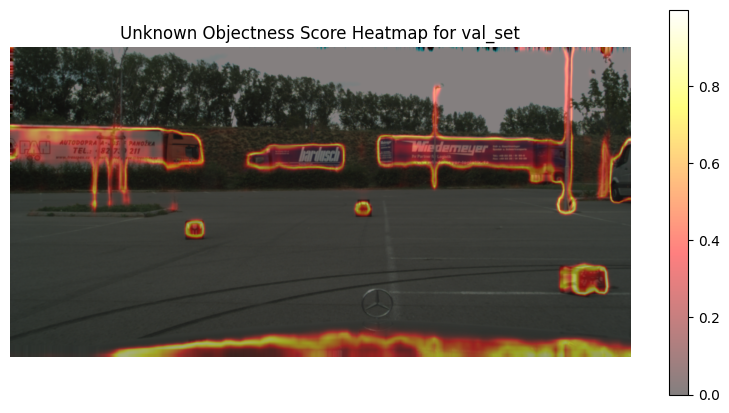

In [51]:
# Visualize the heatmap superposed on the image
idx = 100
img, mask, orig_mask = val_set[idx]

# Load grayscale image (1 channel)
image_path = f"../../lostandfound_f/img/train/train{idx-1}.png"
img_lost_and_found = Image.open(image_path)  # 'L' mode = 8-bit pixels, black and white

resized_height = 512
resized_width = 1024

transform = T.Compose([
    T.Resize((resized_height, resized_width)),  # Resize to half the original size
    T.ToTensor(),  # converts in [0, 1], shape [3, H, W]
    T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

img_lost_and_found = transform(img_lost_and_found)  # Apply the same transformation


# Recreate the model architecture
model = MultiLabelDeepLabV3(n_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = BoundaryAwareBCELoss(lambda_weight=3.0)
model.to(device)  # move to GPU or CPU as appropriate

weight_name = "new_model_boundary_5_lambda_3.0.pth"  # Change this to the desired model name

checkpoint = torch.load('weights/' + weight_name, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return (tensor * std + mean).clamp(0, 1)
#img = denormalize(img)

with torch.no_grad():
    uos = compute_unknown_objectness_score(model(img_lost_and_found.unsqueeze(0).to(device)))[0]
    # plt.imshow(uos.cpu().numpy(), cmap='hot')
    # plt.title(f"UOS for val_set[{idx}]")
    # plt.colorbar()
    # plt.axis('off')
    # plt.show()
img_lost_and_found = denormalize(img_lost_and_found)
uos_heatmap(img_lost_and_found, uos)

## **CONFORMAL PREDICTION**

#### **1. Feasibility of Using Conformal Prediction with Sigmoid Outputs**

Traditional Conformal Prediction (CP) is frequently illustrated with classification models employing softmax outputs, as softmax naturally provides normalized class confidence scores. However, the theoretical foundation of CP does not depend on softmax per se—it only requires a well-calibrated **nonconformity score** that quantifies how atypical or uncertain a prediction is.

In our case:

* We replaced the softmax layer with **per-class sigmoid activations**, which is a valid approach for **multi-label semantic segmentation**, where a pixel may simultaneously belong to multiple classes (e.g., both `"object"` and `"vehicle"`).

* We introduced a **total objectness score**, a measure combining the likelihood of a pixel belonging to the `"object"` class with its unlikeliness of belonging to any known (non-object) class. This score captures how strongly a pixel appears to be part of an obstacle—either known or unknown.

* This total objectness score serves as a principled and expressive **nonconformity function**, particularly suitable for open-set scenarios. **Low objectness** implies conformity with **background** or known non-obstacle classes.
**High objectness** indicates the pixel likely belongs to an **obstacle**.

Hence, using Conformal Prediction in this sigmoid-based framework is not only feasible but especially advantageous for **uncertainty quantification in road obstacle identification**, including both known and unknown objects in the scene.

#### **2. Nonconformity Score: What is the Nonconformity Function For?**

In conformal prediction, the **nonconformity function α(x)** quantifies how **strange or unusual** a new sample x is **with respect to a calibration set**.

-A **high** nonconformity score means the sample is **less similar** to the training/calibration data -> more "uncertain".

-A **low** score means it behaves like samples seen before -> more "conforming".

It is used to rank samples and to derive a threshold during calibration (based on a desired error rate ϵ) so that, at test time, you can decide whether to accept or reject a prediction, or to quantify uncertainty (e.g., assign confidence levels to predictions).

#### **3. Nonconformity Score: How to Define It in This Case?**

Starting from the **unknown objectness score**:

$$
S_{\text{unk-objectness}}(x) = \sigma_{\text{obj}}(x) \cdot \prod_{c \in C} \left(1 - \sigma_c(x)\right)
$$

We define the **total obstacle objectness score** as:
$$
S_{\text{obstacle}}(x) = \sigma_{\text{human}}(x) + \sigma_{\text{vehicle}}(x) + S_{\text{unk-objectness}}(x)
$$

This score quantifies the confidence that a pixel belongs to any road obstacle — either known (human or vehicle) or unknown.

<br>

The **nonconformity score** for conformal prediction is then defined as:
$$
\alpha(x) = 1 - S_{\text{obstacle}}(x)
$$

 ~In which higher values mean more "strangeness" (i.e., more non-conforming)~


This transformation flips the interpretation appropriately:  
a pixel with **low objectness score** gets a **high nonconformity score**, and vice versa.

---

This $\alpha(x)$ is then suitable for:

- Calibrate a threshold $q_{1-\varepsilon}$ on a validation set as the $(1-\varepsilon)$-quantile of the distribution of $\alpha(x)$.

- At test time, for each pixel $x$:
$$
\text{If } \alpha(x) \leq q_{1-\varepsilon}, \text{ classify pixel } x \text{ as belonging to a road obstacle (known or unknown).}
$$
